In [461]:
# Import common libraries
import pandas as pd
import numpy as np
from copy import deepcopy
import importlib


# Import MNE processing
from mne.viz import plot_compare_evokeds
from mne import Epochs, events_from_annotations, set_log_level
from mne_nirs.visualisation import plot_glm_group_topo

# Scikit Learn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Import StatsModels
import statsmodels.formula.api as smf

# Import Plotting Library
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from mne_nirs.statistics import run_glm
import matplotlib as mpl

# Internal Packages
import analysis_tools
import system_file_io
import quality_eval
import dynamic_interval_tools
import glm_analysis
import visualizations

# Reset the cache
importlib.reload(analysis_tools)
importlib.reload(system_file_io)
importlib.reload(dynamic_interval_tools)
importlib.reload(glm_analysis)
importlib.reload(visualizations)

<module 'visualizations' from '/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/visualizations.py'>

In [462]:
# ------------------------------------------------------------------
# Recurring values that we will allow for users to change in the GUI
# ------------------------------------------------------------------

# Length of the measured interval
interval_length = 12

# Time from trigger point being evaluated
tmin = -1
tmax = 12

# How you would like to rename the numeric triggers from Aurora
# trigger_id = None
# trigger_id = {'4': 'Control', '2': 'Neutral', '3': 'Inflam', '1':'Practice'}
trigger_id = {'1': 'Start', '2': 'Neutral', '3': 'Concern'}

# What files would you like to ignore while looping through subjects
ignore = [".DS_Store", "sub-03", ".git", ".gitignore"]

# File path to the folder containing the BIDS data.
# root_dir = '../../LabResearch/IndependentStudy/DataAnalysis/'
root_dir = '../../FV_Prelim_Data'

# Mock data folder to test pulling meta data from folder structure.
# path = "../../LabResearch/IndependentStudy/Data/BIDS-NIRS-Tapping"
# path = "../../LabResearch/IndependentStudy/Data/FA"
path = '../../FV_Prelim_Data'

# Does the study have variable task lengths or does the study follow a block design?
variable_epoch_time = False

# Specifies what columns to use for the GLM constrast. If None, contrast is skipped
# Only two columns can be specified
# columns_for_glm_contrast = ['Neutral', 'Inflam']
columns_for_glm_contrast = ['Neutral', 'Concern']

# Specifies what columns to use for group level analysis.
# columns_for_group_analysis = ['Neutral', 'Inflam']
columns_for_group_analysis = ['Neutral', 'Concern']

In [463]:

def run_group_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis, tmin=None, tmax=None, trigger_id=None):
    # Establish the groups, subject names, and snirf file paths for all subjects
    groups, df = system_file_io.import_data_folder(path, ignore)
    # run the analysis for each group
    glm_dataframes = {}
    for group in groups:
        paths = df[df.eq(group).any(1)]['snirf_path'].to_numpy()

        # Processes all Epochs with proper timestamps and collects it in all_epochs
        # all_data is dict of epoch, condition, raw_haemo, raw_intensity, and f_path for all subs
        all_epochs, all_data, all_evokeds = analysis_tools.aggregate_epochs(paths=paths, trigger_id=trigger_id, variable_epoch_time = variable_epoch_time)

        # Process the GLM for all participants in the group into a list of design matrixes
        glm_data = glm_analysis.create_design_matrix(all_data, tmin, tmax)
        print("GLM Data Processed ---> Calcuating GLM Dataframe")
        print(glm_data, columns_for_glm_contrast)
        
        # Converts the glm design matrixes into a dataframe
        df_cha, df_con = glm_analysis.create_glm_df(glm_data, columns_for_glm_contrast)

        print(df_cha)
        print("GLM Dataframe Generated. Finding all significant channels")
        # Find the groups significant channels
        significant_channels = analysis_tools.find_significant_channels(df_cha)

        glm_dataframes[group] = {"channels_df": df_cha, "contrasts_df": df_con, "significant_channels": significant_channels, "all_data": all_data}
        
    return glm_dataframes, all_epochs, all_evokeds

In [464]:
def run_individual_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis, tmin=None, tmax=None, trigger_id=None):
    groups, df = system_file_io.import_data_folder(path, ignore)
    # run the analysis for each group
    glm_dataframes = {}

    paths = df[df.any(1)]['snirf_path'].to_numpy()

    for id, path in enumerate(paths):
        # Processes all Epochs with proper timestamps and collects it in all_epochs
        # all_data is dict of epoch, condition, raw_haemo, raw_intensity, and f_path for all subs
        all_epochs, all_data, all_evokeds = analysis_tools.aggregate_epochs(paths=[path], trigger_id=trigger_id, variable_epoch_time = variable_epoch_time)

        # Process the GLM for all participants in the group into a list of design matrixes
        glm_data = glm_analysis.create_design_matrix(all_data, tmin, tmax)

        # Converts the glm design matrixes into a dataframe
        df_cha, df_con = glm_analysis.create_glm_df(glm_data, columns_for_glm_contrast)

        # Find the groups significant channels
        significant_channels = analysis_tools.find_significant_channels(df_cha)

        glm_dataframes[f'sub-{id+1}'] = {"channels_df": df_cha, "contrasts_df": df_con, "significant_channels": significant_channels, "all_data": all_data}
        
    return glm_dataframes, all_epochs, all_evokeds

In [465]:
importlib.reload(glm_analysis)
group_data, all_epochs, all_evokeds = run_group_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis, tmin=tmin, tmax=tmax, trigger_id=trigger_id)
group_data

Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-08/nirs/2023-02-17_002.snirf
Reading 0 ... 9088  =      0.000 ...   893.350 secs...
Events [86  0  1]
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-01/nirs/2023-02-17_002.snirf
Reading 0 ... 8713  =      0.000 ...   856.488 secs...
Events [66  0  1]
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-06/nirs/2023-02-10_004.snirf
Reading 0 ... 9282  =      0.000 ...   912.421 secs...
Events [103   0   2]
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-07/nirs/2023-02-17_001.snirf
Reading 0 ... 9460  =      0.000 ...   929.918 secs...
Events [110   0   1]
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-09/nirs/2023-03-01_004.snirf
Reading 0 ... 13102  =      0.000 ...  1287.927 secs...
Events [407   0 

{'all_groups': {'channels_df': variable Condition    df           mse   p_value            se         t  \
0          Concern  21.0  4.126853e-12  0.178745  6.263993e-07  1.391148   
1          Neutral  21.0  4.126853e-12  0.738956  6.273092e-07  0.337680   
2            Start  21.0  4.126853e-12  0.655185  2.149083e-06  0.453013   
3         constant  21.0  4.126853e-12  0.689450  4.733191e-07 -0.405171   
4          drift_1  21.0  4.126853e-12  0.992607  1.194597e-05 -0.009377   
...            ...   ...           ...       ...           ...       ...   
19327      drift_5  21.0  1.377884e-12  0.828446  1.010108e-05 -0.219414   
19328      drift_6  21.0  1.377884e-12  0.949157  9.977163e-06  0.064532   
19329      drift_7  21.0  1.377884e-12  0.977449  9.903960e-06 -0.028606   
19330      drift_8  21.0  1.377884e-12  0.833963  9.831958e-06  0.212244   
19331      drift_9  21.0  1.377884e-12  0.847722  9.771250e-06  0.194412   

variable         theta Source Detector Chroma  Significa

In [466]:
# individual_data, all_epochs, all_evokeds = run_individual_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis, trigger_id)
# individual_data

# Visualizations

In [478]:
# Group Visualization
importlib.reload(visualizations)
groups = list(group_data.keys())
for group in groups:
    # channels_df, contrasts_df, significant_channels, all_data = group_data['direct'].values()
    channels_df, contrasts_df, significant_channels, all_data = group_data[group].values()

    raw_haemo = all_data[0]['raw_haemo']

    visualizations.group_topological_visualisation(channels_df, columns_for_glm_contrast, raw_haemo)

['Condition', 'df', 'mse', 'p_value', 'se', 't', 'theta', 'Source', 'Detector', 'Chroma', 'Significant', 'ch_name', 'ID']
PLOT GLM GROUP TOPO FIRING


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


KeyError: 'theta'

Concern 8
combining channels using "mean"
Neutral 8
combining channels using "mean"
Start 8
combining channels using "mean"
Concern 8
combining channels using "mean"
Neutral 8
combining channels using "mean"
Start 8
combining channels using "mean"


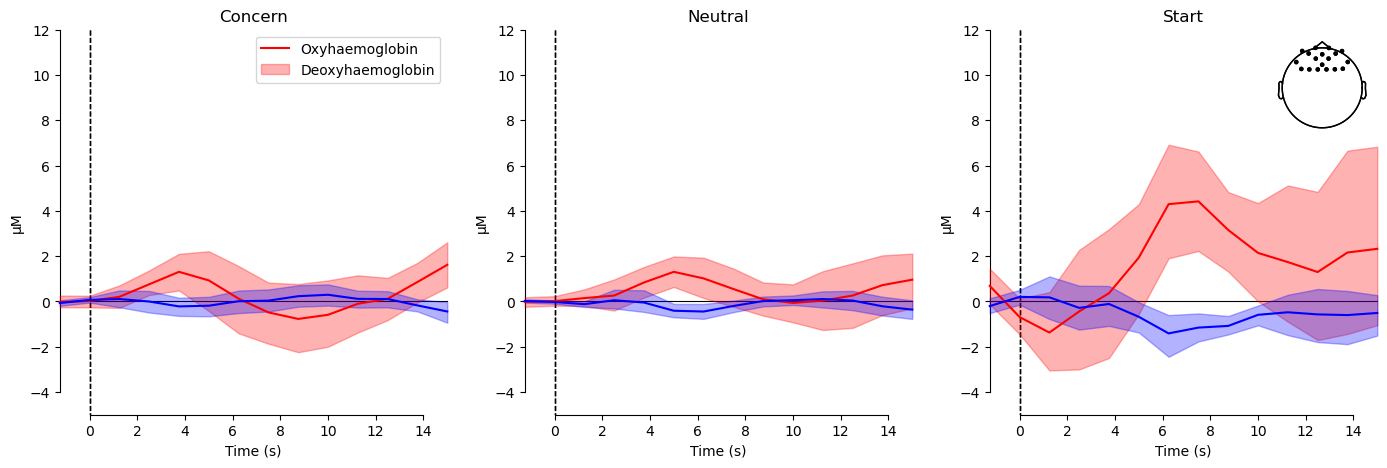

In [468]:
importlib.reload(visualizations)
visualizations.plot_waveform_analysis(all_evokeds, variable_epoch_time)

# Statistical Summary

In [469]:
# Generate a summarized dataframe of the channels and conditions significance
importlib.reload(analysis_tools)

ch_model_df = analysis_tools.create_results_dataframe(channels_df, columns_for_glm_contrast, raw_haemo)


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Coef. Std.Err.         z     P>|z|    [0.025  \
ch_name   Condition                                                        
S1_D1 hbr Concern    2.125231e-07      0.0  1.221114  0.222043      -0.0   
          Neutral   -2.206002e-08      0.0 -0.126752  0.899136      -0.0   
S1_D2 hbr Concern    2.797780e-07      0.0  1.607547  0.107934      -0.0   
          Neutral    8.050667e-08      0.0  0.462575  0.643669      -0.0   
S2_D1 hbr Concern    5.069335e-07      0.0  2.912735  0.003583       0.0   
          Neutral    3.557561e-07      0.0  2.044101  0.040944       0.0   
S2_D3 hbr Concern    3.724121e-07      0.0  2.139803  0.032371       0.0   
          Neutral    5.510474e-07      0.0  3.166205  0.001544       0.0   
S3_D3 hbr Concern    5.210242e-07      0.0  2.993698  0.002756       0.0   
          Neutral    3.511231e-07      0.0  2.017481  0.043645       0.0   
S3_D4 hbr Concern    8.248438e-09      0.0  0.047394  0.962199      -0.0   
          Neutral   -2.377704e-07      0.0 -1.366180  0.171883 -0.000001   
S4_D2 hbr Concern    2.765305e-07      0.0  1.588887  0.112086      -0.0   
          Neutral    1.180400e-07      0.0  0.678233  0.497624      -0.0   
S4_D4 hbr Concern    6.773410e-07      0.0  3.891862  0.000099       0.0   
          Neutral   -3.473659e-07      0.0 -1.995893  0.045946 -0.000001   
S4_D5 hbr Concern    3.540675e-07      0.0  2.034399  0.041911       0.0   
          Neutral   -4.324967e-07      0.0 -2.485037  0.012954 -0.000001   
S5_D3 hbr Concern    1.603688e-07      0.0  0.921446  0.356818      -0.0   
          Neutral    7.281800e-08      0.0  0.418397  0.675657      -0.0   
S5_D4 hbr Concern   -9.159317e-08      0.0 -0.526275  0.598697      -0.0   
          Neutral   -1.162676e-08      0.0 -0.066805  0.946737      -0.0   
S5_D6 hbr Concern    3.348903e-08      0.0  0.192421  0.847412      -0.0   
          Neutral    2.896285e-07      0.0  1.664146  0.096083      -0.0   
S6_D4 hbr Concern   -1.590164e-07      0.0 -0.913675  0.360887 -0.000001   
          Neutral    4.602892e-08      0.0  0.264473  0.791416      -0.0   
S6_D6 hbr Concern    2.703394e-07      0.0  1.553314  0.120348      -0.0   
          Neutral    5.419749e-07      0.0  3.114076  0.001845       0.0   
S7_D5 hbr Concern    2.230124e-08      0.0  0.128138  0.898039      -0.0   
          Neutral   -6.123972e-08      0.0 -0.351871  0.724935      -0.0   
S7_D7 hbr Concern    1.843545e-07      0.0  1.059263  0.289480      -0.0   
          Neutral    1.699649e-07      0.0  0.976583  0.328775      -0.0   
S8_D6 hbr Concern    3.746900e-07      0.0  2.152892  0.031327       0.0   
          Neutral    5.771105e-07      0.0  3.315958  0.000913       0.0   
S8_D7 hbr Concern    4.662313e-07      0.0  2.678869  0.007387       0.0   
          Neutral    5.168546e-07      0.0  2.969740  0.002981       0.0   

                       0.975] Chroma  Significant  
ch_name   Condition                                
S1_D1 hbr Concern    0.000001    hbr        False  
          Neutral         0.0    hbr        False  
S1_D2 hbr Concern    0.000001    hbr        False  
          Neutral         0.0    hbr        False  
S2_D1 hbr Concern    0.000001    hbr         True  
          Neutral    0.000001    hbr         True  
S2_D3 hbr Concern    0.000001    hbr         True  
          Neutral    0.000001    hbr         True  
S3_D3 hbr Concern    0.000001    hbr         True  
          Neutral    0.000001    hbr         True  
S3_D4 hbr Concern         0.0    hbr        False  
          Neutral         0.0    hbr        False  
S4_D2 hbr Concern    0.000001    hbr        False  
          Neutral         0.0    hbr        False  
S4_D4 hbr Concern    0.000001    hbr         True  
          Neutral        -0.0    hbr         True  
S4_D5 hbr Concern    0.000001    hbr         True  
          Neutral        -0.0    hbr         True  
S5_D3 hbr Concern    0.000001    hbr        False  
          Neutral         0.0    hbr        Fal

In [ ]:

ch_model_df['hbr']

In [471]:
ch_model_df['hbo']

Coef. Std.Err.         z     P>|z|    [0.025  \
ch_name   Condition                                                        
S1_D1 hbo Concern   -7.825836e-07      0.0 -1.604841  0.108529 -0.000002   
          Neutral    2.434547e-09      0.0  0.004993  0.996017 -0.000001   
S1_D2 hbo Concern    5.578920e-08      0.0  0.114407  0.908915 -0.000001   
          Neutral    2.004797e-07      0.0  0.411123  0.680982 -0.000001   
S2_D1 hbo Concern   -1.406295e-06      0.0 -2.883885  0.003928 -0.000002   
          Neutral   -1.198501e-06      0.0 -2.457761  0.013981 -0.000002   
S2_D3 hbo Concern   -9.964516e-07      0.0 -2.043419  0.041011 -0.000002   
          Neutral   -1.694544e-06      0.0 -3.474995  0.000511 -0.000003   
S3_D3 hbo Concern   -1.516254e-06      0.0 -3.109377  0.001875 -0.000002   
          Neutral   -1.059560e-06      0.0 -2.172836  0.029793 -0.000002   
S3_D4 hbo Concern    1.636222e-07      0.0  0.335539  0.737218 -0.000001   
          Neutral    7.295903e-07      0.0  1.496168  0.134610      -0.0   
S4_D2 hbo Concern    3.406313e-07      0.0  0.698531  0.484845 -0.000001   
          Neutral    6.511612e-07      0.0  1.335334  0.181767      -0.0   
S4_D4 hbo Concern   -3.645999e-07      0.0 -0.747684  0.454651 -0.000001   
          Neutral    1.165493e-06      0.0  2.390072  0.016845       0.0   
S4_D5 hbo Concern    1.442936e-07      0.0  0.295902  0.767305 -0.000001   
          Neutral    1.465171e-06      0.0  3.004621  0.002659  0.000001   
S5_D3 hbo Concern   -2.955461e-07      0.0 -0.606075  0.544465 -0.000001   
          Neutral   -3.261497e-08      0.0 -0.066883  0.946675 -0.000001   
S5_D4 hbo Concern    1.828740e-07      0.0  0.375019  0.707646 -0.000001   
          Neutral   -3.071811e-08      0.0 -0.062994  0.949772 -0.000001   
S5_D6 hbo Concern   -1.500465e-07      0.0 -0.307700  0.758311 -0.000001   
          Neutral   -9.782750e-07      0.0 -2.006145  0.044841 -0.000002   
S6_D4 hbo Concern    4.414026e-07      0.0  0.905183  0.365369 -0.000001   
          Neutral   -1.399872e-07      0.0 -0.287071  0.774058 -0.000001   
S6_D6 hbo Concern   -9.003483e-07      0.0 -1.846341  0.064843 -0.000002   
          Neutral   -1.592307e-06      0.0 -3.265338  0.001093 -0.000003   
S7_D5 hbo Concern   -5.144074e-08      0.0 -0.105489  0.915988 -0.000001   
          Neutral    9.799907e-08      0.0  0.200966  0.840725 -0.000001   
S7_D7 hbo Concern   -4.724879e-07      0.0 -0.968929  0.332581 -0.000001   
          Neutral   -1.572319e-07      0.0 -0.322435  0.747123 -0.000001   
S8_D6 hbo Concern   -1.227617e-06      0.0 -2.517470  0.011820 -0.000002   
          Neutral   -1.822803e-06      0.0 -3.738016  0.000185 -0.000003   
S8_D7 hbo Concern   -1.457301e-06      0.0 -2.988482  0.002804 -0.000002   
          Neutral   -1.456601e-06      0.0 -2.987045  0.002817 -0.000002   

                       0.975] Chroma  Significant  
ch_name   Condition                                
S1_D1 hbo Concern         0.0    hbo        False  
          Neutral    0.000001    hbo        False  
S1_D2 hbo Concern    0.000001    hbo        False  
          Neutral    0.000001    hbo        False  
S2_D1 hbo Concern        -0.0    hbo         True  
          Neutral        -0.0    hbo         True  
S2_D3 hbo Concern        -0.0    hbo         True  
          Neutral   -0.000001    hbo         True  
S3_D3 hbo Concern   -0.000001    hbo         True  
          Neutral        -0.0    hbo         True  
S3_D4 hbo Concern    0.000001    hbo        False  
          Neutral    0.000002    hbo        False  
S4_D2 hbo Concern    0.000001    hbo        False  
          Neutral    0.000002    hbo        False  
S4_D4 hbo Concern    0.000001    hbo        False  
          Neutral    0.000002    hbo         True  
S4_D5 hbo Concern    0.000001    hbo        False  
          Neutral    0.000002    hbo         True  
S5_D3 hbo Concern    0.000001    hbo        False  
          Neutral    0.000001    hbo        Fal

In [470]:
# Individual Visualization
importlib.reload(visualizations)
if individual_data:
    channels_df, contrasts_df, significant_channels, all_data = individual_data['sub-1'].values()

    raw_haemo = all_data[0]['raw_haemo']

    visualizations.group_topological_visualisation(channels_df, columns_for_glm_contrast, raw_haemo)

1
PLOT GLM GROUP TOPO FIRING
PLOT GLM GROUP TOPO FIRING


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2705: RuntimeWarning: invalid value encountered in sqrt
  sdf[0:self.k_fe, 1] = np.sqrt(np.diag(self.cov_params()[0:self.k_fe]))
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/mne_nirs/statistics/_statsmodels.py:102: RuntimeWarning: invalid value encountered in sqrt
  stderr = np.sqrt(np.diag(model.cov_params()[sl]))
/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/visualizations.py:66: RuntimeWarning: MNE data structure does not match regression results
  plot_glm_group_topo(raw_haemo.copy().pick(picks=chroma),


AssertionError: Only one Chroma allowed